# Computing expectiles

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

from gmm import EXAMPLE

## Example distribution

We'll want an example multi-modal distribution to play around with.

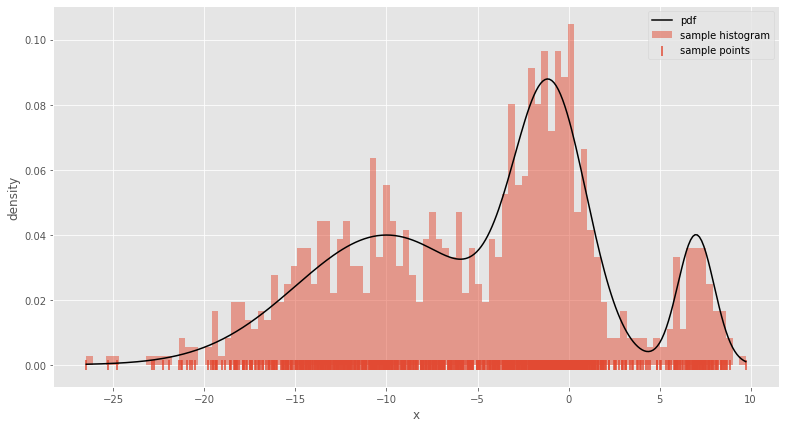

In [3]:
SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000)

$$
\newcommand{\iv }[1]{{[\hspace{-1.5pt}[#1]\hspace{-1.5pt}]}}
\newcommand{\ivt}[3]{{\iv{#1}_{#3}^{#2}}}
$$

## Expectile Regression

Given a distribution $\eta$ with finite second moment, and a $\tau \in [0, 1]$, the $\tau$-expectile of $\eta$, $\epsilon_\tau$ is defined to be the minimising $\epsilon$ of the expectile regression loss $ER(\epsilon; \eta, \tau)$ given by

$$ER(\epsilon;\eta,\tau) = \mathbb{E}_{Z \sim \eta}((\tau\iv{Z \gt \epsilon} + (1-\tau)\iv{Z \leq \epsilon})(Z-\epsilon)^2)$$

ER loss simplifies to

\begin{align*}
    ER(\epsilon;\eta,\tau)
    &=
    \tau\mathbb{E}(\iv{Z \gt \epsilon}(Z-\epsilon)^2) + (1-\tau)\mathbb{E}(\iv{Z \leq \epsilon}(Z-\epsilon)^2)
    \\
    &=
    \tau\int_{z \gt \epsilon}f(z)(z-\epsilon)^2 dz
    \quad
    +
    \quad
    (1-\tau)\int_{z \leq \epsilon}f(z)(z-\epsilon)^2 dz
\end{align*}

where $f(z)$ is the probability density function of the distribution $\eta$.

This shows that the loss is optimised when $\epsilon$ balances a kind of expected squared variation above and below itself, while considering these variations to be unequally important (according to $\tau$ and $1-\tau$, respectively).

#### Notes

ER loss is related to other 'losses' in statistics.

* ER loss is an asymmetric version of the 'square loss', where we consider variation above and below $\epsilon$ equally (as if $\tau=0.5$). The minimiser for the 'square loss' is $\mathbb{E}(Z)$, the *mean*.
* Similarly, we can consider 'quantile regression', where we use the 'quantile loss', an asymmetric version of the absolute value loss. The $\tau=0.5$ quantile is the *median*.
* It's in this sense that "expectiles generalise the mean in the same way that quantiles generalise the median".

## Calculating expectiles

The ER loss function is convex and should be easy to numerically optimise. Thus, we can easily calulate $\epsilon_\tau$ of a finite sample's empirical distribution using numerical optimisation:

In [17]:
def ER_loss(eps, tau, sample):
    n = len(sample)
    above_loss = 1/n * np.sum(np.square(sample[sample  > eps] - eps))
    below_loss = 1/n * np.sum(np.square(sample[sample <= eps] - eps))
    return tau * above_loss + (1-tau) * below_loss

def expectile_opt(sample, taus):
    """
    compute sample expectiles for multiple taus using optimisation routine
    """
    return [opt.minimize(lambda eps: ER_loss(eps, tau, sample), x0=0).x[0] for tau in taus]




Alternatively, we can express the relationship between $\tau$ and $\epsilon_\tau$ through the derivative of the ER.

\begin{align*}
    -\frac{1}{2}\frac{\partial}{\partial \epsilon} ER(\epsilon;\eta,\tau)
    &=
    \tau\int_{z \gt \epsilon}f(z)(z-\epsilon) dz
    \quad
    +
    \quad
    (1-\tau)\int_{z \leq \epsilon}f(z)(z-\epsilon) dz
    \\
    &=0\qquad\text{(when $\epsilon=\epsilon_\tau$)}
\end{align*}

With some rearrangement, and by introducing

* the cumulative distribution function $F(\epsilon)=\int_{z\leq\epsilon}f(z)dz$,
* the 'partial moment function' $M(\epsilon) = \int_{z\leq\epsilon}z f(z) dz$, and
* the mean $\mu = \int_z z f(z) dz$,

we arrive at the equation:

$$
0
=
 (1-\tau)M(\epsilon_\tau) + \tau(\mu-M(\epsilon_\tau))
-
\epsilon_\tau(
 (1-\tau)F(\epsilon_\tau) + \tau(1-F(\epsilon_\tau))
)
$$

For fixed $\tau$, the RHS expression is a monotonically decreasing function of $\epsilon_\tau$, as shown below for various $\tau$.

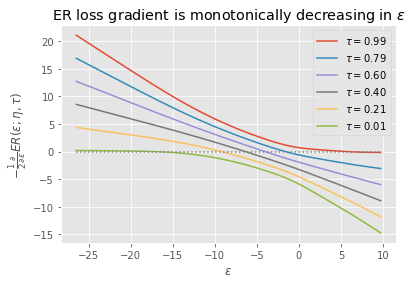

In [6]:
sorted_sample = np.sort(sample)
N = len(sorted_sample)
F = np.cumsum(np.ones_like(sorted_sample)/N)
M = np.cumsum(sorted_sample / N)
mean = M[-1]

for tau in reversed(np.linspace(0.01, 0.99, 6)):
    prob_balance = ((1 - tau) * F + tau * (1 - F))
    mean_balance = ((1 - tau) * M + tau * (mean - M))
    balance = mean_balance - sorted_sample * prob_balance
    plt.plot(sorted_sample, balance, label=f"$\\tau={tau:.2f}$")

lohi = sorted_sample[0], sorted_sample[-1]
plt.plot(lohi, [0, 0], linestyle=":", color="gray")
plt.ylabel(r"$-\frac{1}{2}\frac{\partial}{\partial \epsilon} ER(\epsilon;\eta,\tau)$")
plt.xlabel(r"$\epsilon$")
plt.title(r"ER loss gradient is monotonically decreasing in $\epsilon$")
plt.legend(loc="upper right")
plt.show()

Moreover, $M$ and $F$ are easily computed cumulatively from a finite sample, and can then be queried efficienty at any sample point (noting that their value only changes at sample points).

This suggests a slightly more direct way to compute $\epsilon_\tau$:

1. Sort the sample.
2. Precompute the partial moments $M$ and cumulative probabilities $F$ at each sample point.
3. Scan through the sample points in increasing order evaluating the derivative, until it first passes 0.
4. The sample expectile will be somewhere between the last two sample points queried.

For simplicy, we could just report the sample point with the lowest absolute gradient as the expectile. Or, since for $\epsilon$ between these two points, $M(\epsilon)$ and $F(\epsilon)$ are constant (and equal to $M(\epsilon_{+})$ and F($\epsilon_{+})$ respectively, where $\epsilon_{+}$ is the final positive-gradient sample point), we can directly solve for the exact expectile:

$$
\epsilon_\tau
=
\frac{
    (1-\tau)M(\epsilon_{+}) + \tau(\mu-M(\epsilon_+))
}{
    (1-\tau)F(\epsilon_+) + \tau(1-F(\epsilon_+))
}
$$




In [18]:
def expectile(sample, tau, interpolation=True):
    """
    Compute the tau-th expectile from a sample.

    Parameters:
        sample (array-like): sample to compute expectiles of
        tau (float or array-like of floats): asymmetric ratio or ratios
            of expectiles to compute, each between 0 and 1 inclusive
        interpolation (bool): True for computing exact expectile between
            two sample points, False to return previous sample point
            (default True).

    Returns:
        expectiles (np.ndarray): vector of computed expectiles
    """
    sorted_sample = np.sort(sample)
    n = len(sample)
    M = np.cumsum(sorted_sample/n)
    F = np.cumsum(np.ones_like(sorted_sample)/n)
    m = M[-1] # mean
    # candidate expectiles (where M[i], F[i] change):
    e = sorted_sample
    # for each t:
    # find the e where this equation is satisfied:
    # 0 = (1-t)M(e) + t(m-M(e)) - e((1-t)F(e) + t(1-F(e)))
    if np.isscalar(tau): tau = [tau]
    expectiles = np.ndarray(len(tau))
    for j, t in enumerate(tau):
        imbalance = (1-t)*M + t*(m-M) - e*((1-t)*F + t*(1-F))
        i = np.argmin(np.abs(imbalance))
        if t == 1:
            e_star = e[-1]
        elif not interpolation or imbalance[i] == 0:
            e_star = e[i]
        # optionally, refine answer to *exact* expectile in case it's
        # between two sample points:
        elif imbalance[i] > 0:
            # go a little further!
            e_star = ((1-t)*M[i] + t*(m-M[i])) / ((1-t)*F[i] + t*(1-F[i]))
        else:
            # go back a little bit!
            e_star = ((1-t)*M[i-1]+t*(m-M[i-1])) / ((1-t)*F[i-1]+t*(1-F[i-1]))
        expectiles[j] = e_star
    return expectiles

The direct method for calculating the sample expectile is slightly faster than the optimisation-based method, presumably because of the savings gained by pre-computing the partial moments and cumulative probabilities, and, further, sharing these across various values of $\tau$.

In [19]:
# compute 99 expectiles between tau=1% and tau=99%
taus = np.linspace(0.01, 0.99, 99)

print("direct method")
%timeit expectile(sample, taus)

print("\nopt-based method")
%timeit expectile_opt(sample, taus)

direct method
5.88 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

opt-based method
245 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Further, the approximation of using a sample point as the expectile seems to be fair, at least when we have so many samples as in this case (there is likely to be one close to the true value of the expectile).

total absolute error from approximating optimum using a sample point
1.4219332613728513


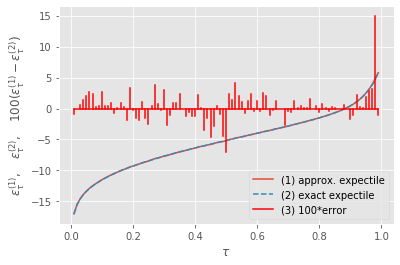

In [20]:
taus = np.linspace(0.01, 0.99, 99)

r1 = np.array(expectile(sample, taus, interpolation=False))
r2 = np.array(expectile(sample, taus, interpolation=True))

print("total absolute error from approximating optimum using a sample point")
print(np.sum(np.abs(r2-r1)))

plt.plot(taus, r1, linestyle="-",  label="(1) approx. expectile")
plt.plot(taus, r2, linestyle="--", label="(2) exact expectile")

for t, d in zip(taus, 100*(r1-r2)):
    plt.plot([t,t], [0,d], color="red")
plt.plot([0.01, 0.99], [0, 0], color="red", label="(3) 100*error")

plt.legend(loc="lower right")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\epsilon_\tau^{(1)},\quad\epsilon_\tau^{(2)},\quad100(\epsilon_\tau^{(1)}-\epsilon_\tau^{(2)})$")
plt.show()